# Load 15min Fitbit data and train patient model

In [1]:
%cd /hpc/users/jegmij01/jannes_setup/cpp_project

/hpc/users/jegmij01/jannes_setup/cpp_project


In [2]:
# custom modules
import config
from features import preprocessing as pp
from helpers import io_helpers as io
from helpers import plot_helpers as pics

from matplotlib import pyplot as plt

# Load data

In [3]:
# from data.datasets import Dataset_CPP
import pickle
filepath = config.DATA_PATH / 'private/cpp/20240820pkls/min15.pkl'
with open(filepath, 'rb') as f:
    raw_data = pickle.load(f)

# Create raw_data images

100%|██████████| 81/81 [00:00<00:00, 1712.52it/s]
/hpc/users/jegmij01/jannes_setup/cpp_project/helpers/io_helpers.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X_imputed).astype(float)


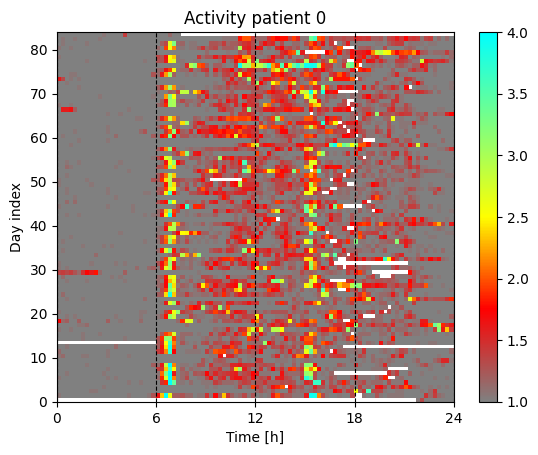

In [4]:
for p_idx in raw_data.keys():
    
    if len(raw_data[p_idx]) == 0: # or p_idx < 54: 
        print('skip .. no data in raw_data object for p_idx', p_idx)
        continue
    
    dfs = io.get_person_data(raw_data,p_idx)
    arr = io.get_nan_imputed_array(dfs)
        
    if len(arr) < 20:
        print(p_idx, 'too few days', arr.shape)
        continue
    
    ax=pics.arr_to_pcolor_plt(arr)
    ax.set_title(f'Activity patient {p_idx}')

    #break
    #pic.savefig(f'patient_{p_idx}_15min_grid', fig_path=config.fig_path)
    plt.show()
    plt.close()
    break

# Linear baseline for Auto-Regression Task

In [10]:
from data.datasets import Dataset_CPP
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from models import pytorch_models

import numpy as np
import pandas as pd

In [6]:
prediction_horizon = 2 # two steps => 30 min
look_back_window = 10 # 10 steps => 2:30h

all_data = Dataset_CPP(config.DATA_PATH, 
                       data_path='private/cpp/20240820pkls/min15.pkl', 
                       features='activity',
                       size=[look_back_window, 0, prediction_horizon], 
                       scale=False, 
                       use_time_features=True,
                       split='all') # no train,  val, test splits

num of subjects in train, val, test 65 10 19
1326 timesteps lost as fraction 0.003732046912336301


In [7]:
generator = io.yield_subject_arrays(all_data)
hours, hours_y, weekdays, days, days_y, x, y = next(generator)

In [30]:
import importlib # for dev
importlib.reload(pytorch_models)

<module 'models.pytorch_models' from '/hpc/users/jegmij01/jannes_setup/cpp_project/models/pytorch_models.py'>

### Apply linear baseline for one patient

In [31]:
# Usage
n = 1000  # validation split
batch_size = 32

x_train = torch.from_numpy(x[:n]).float() 
y_train = torch.from_numpy(y[:n]).float()
x_val = torch.from_numpy(x[-n:]).float()
y_val = torch.from_numpy(y[-n:]).float()

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=len(x_val), shuffle=False)

# Model, loss function, and optimizer setup
model = pytorch_models.LinearBaseline()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

trainer = pytorch_models.ModelTrainer(model, loss_fn, optimizer, epochs=500)
trainer.train(train_loader, val_loader)

predictions = trainer.predict(val_loader)

Epoch [1/500], Training Loss: 2.83145, Validation Loss: 1.11976
Epoch [2/500], Training Loss: 0.70558, Validation Loss: 1.04164
Epoch [3/500], Training Loss: 0.83796, Validation Loss: 0.96998
Epoch [4/500], Training Loss: 1.23471, Validation Loss: 0.90391
Epoch [5/500], Training Loss: 0.75391, Validation Loss: 0.84230
Epoch [6/500], Training Loss: 2.60161, Validation Loss: 0.78517
Epoch [7/500], Training Loss: 0.35519, Validation Loss: 0.73193
Epoch [8/500], Training Loss: 0.37497, Validation Loss: 0.68423
Epoch [9/500], Training Loss: 0.33475, Validation Loss: 0.64034
Epoch [10/500], Training Loss: 0.65126, Validation Loss: 0.59962
Epoch [11/500], Training Loss: 0.18293, Validation Loss: 0.56210
Epoch [12/500], Training Loss: 0.26924, Validation Loss: 0.52854
Epoch [13/500], Training Loss: 1.38949, Validation Loss: 0.49684
Epoch [14/500], Training Loss: 0.57510, Validation Loss: 0.46773
Epoch [15/500], Training Loss: 1.09610, Validation Loss: 0.44154
Epoch [16/500], Training Loss: 0.1

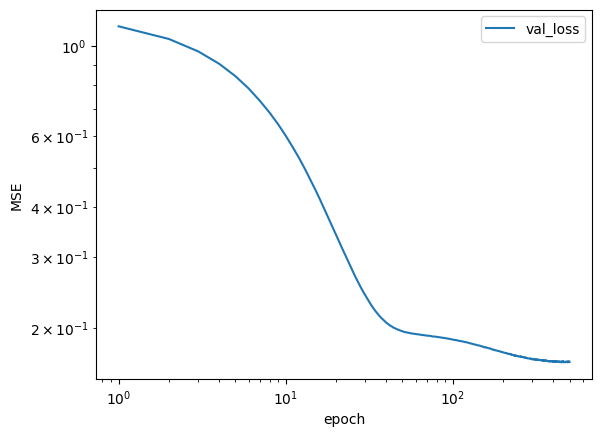

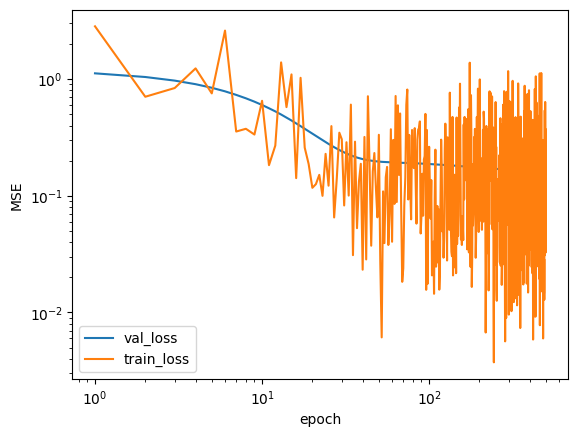

In [36]:
res, ax = trainer.plot_results(include_training=False)
plt.show(), plt.close()
res, ax = trainer.plot_results(include_training=True)
plt.show()

### Moving window: input, prediction vs true

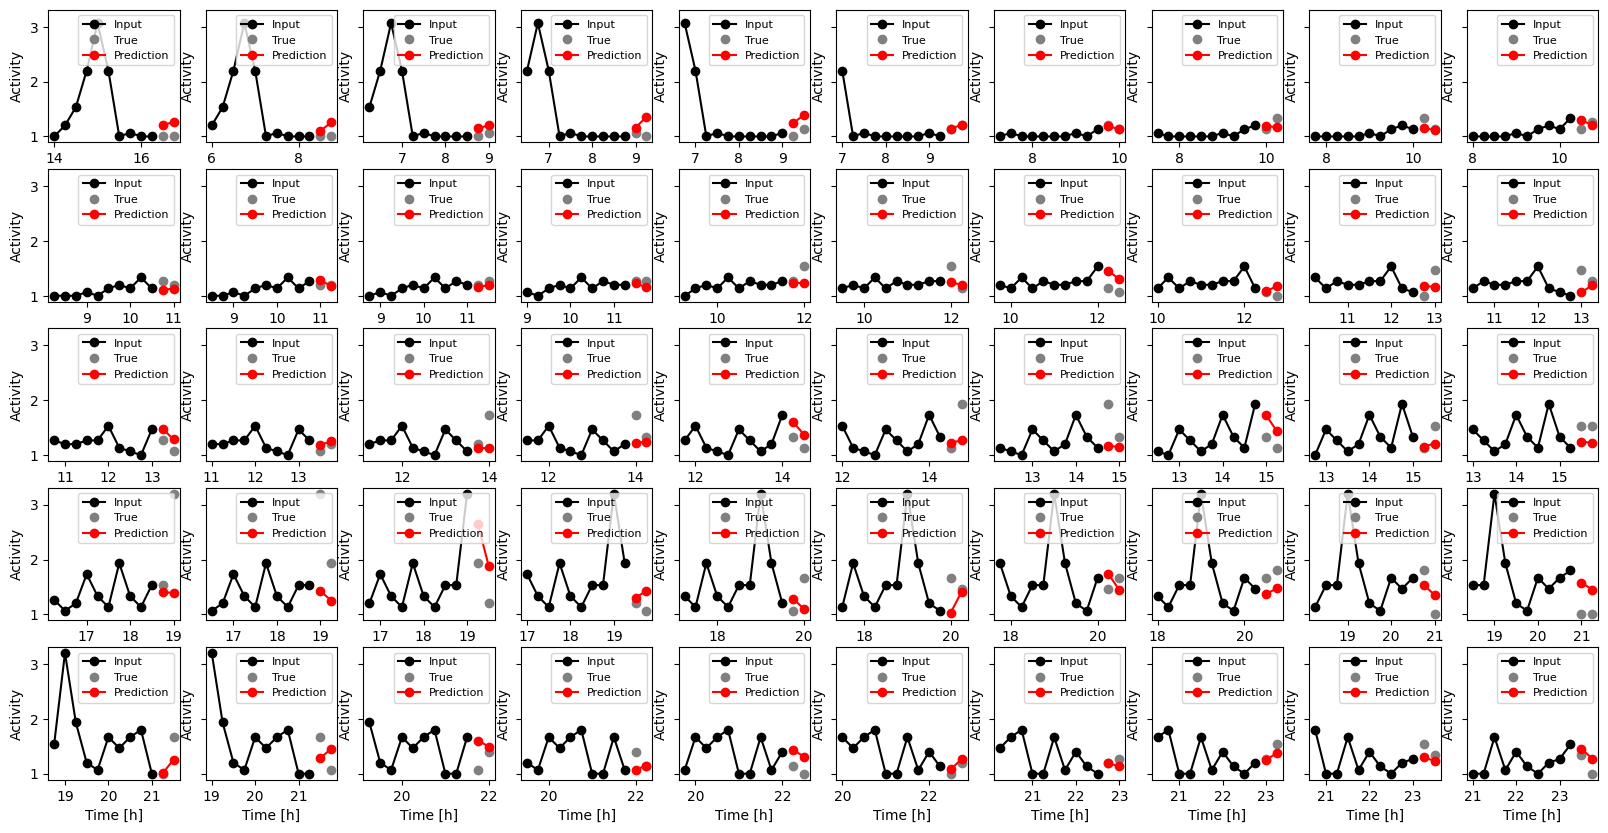

In [24]:
# Assuming val_output is available from your validation step
f, axs = plt.subplots(5, 10, figsize=[20, 10], sharex=False, sharey=True)
_ = [pics.plot_segment(ax, t, hours_y[n:], y_val.numpy(), predictions, hours[n:], x=x_val.numpy()) for (t, ax) in enumerate(axs.reshape(-1))]

### True vs predictions per day

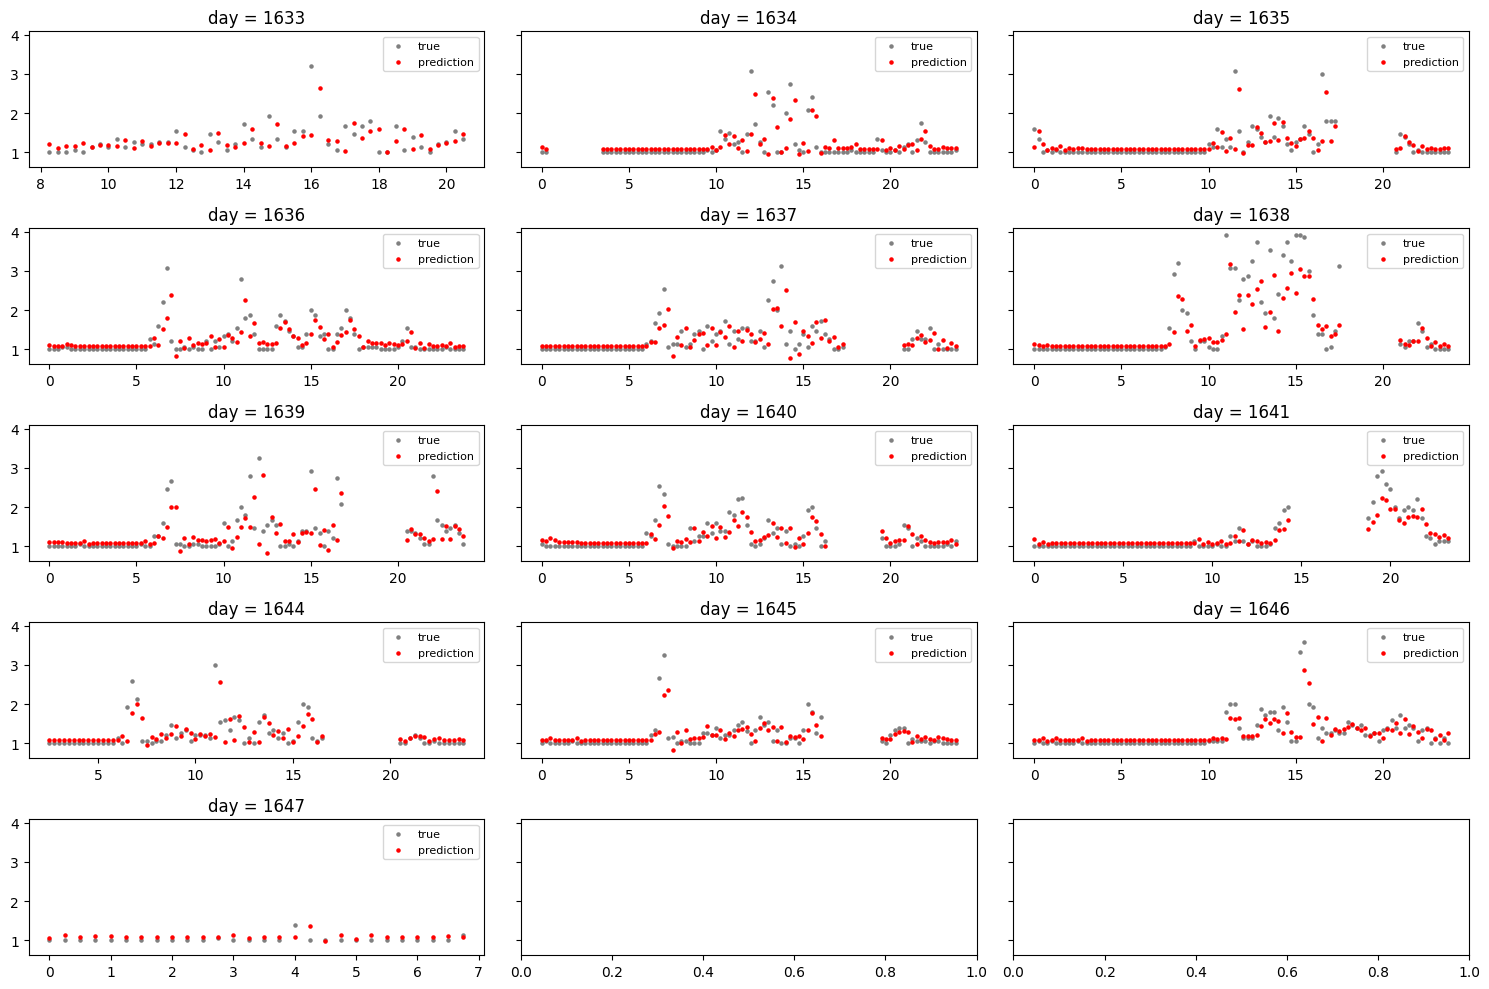

In [25]:
f,axs=plt.subplots(5,3, figsize=[15,10], sharex=False, sharey=True, tight_layout=True)
hours_y_val, days_y_val = hours_y[-n:], days_y[-n:]
_ = [pics.plot_day(ax, day, hours_y_val , days_y_val, y_val.numpy(), predictions) 
     for (day,ax) in zip(np.unique(days_y_val), axs.reshape(-1))]

### AUC curves

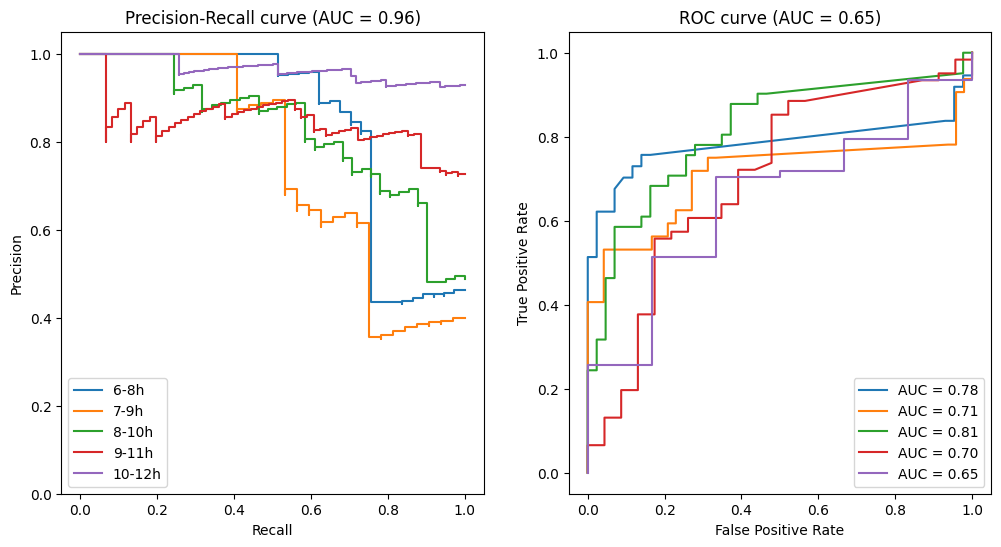

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

labels = []
for t in range(6,11):
    pics.plot_auc_for_val(tmin=t, tmax=t+2, ax1=ax1, ax2=ax2, predictions=predictions, y_val=y_val.numpy(), hours_y_val=hours_y_val)
    labels.append(f'{t}-{t+2}h')
ax1.legend(labels)

Impressum: 
- Jannes Jegminat, 24-10-31